In [1]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
# Path to the directory containing pickle files
dir_path = '/storage/vbutoi/scratch/ESE/records/WMH_aug_runs'

# List all pickle files in the directory
pickle_files = [f for f in os.listdir(dir_path) if f.endswith('.pkl')]

# Initialize an empty DataFrame
all_logs = pd.DataFrame()

# Iterate through each pickle file and append its contents to the DataFrame
for p_file in pickle_files:
    file_path = os.path.join(dir_path, p_file)
    temp_df = pd.read_pickle(file_path)
    all_logs = pd.concat([all_logs, temp_df], ignore_index=True)

In [3]:
all_logs

,accuracy,bin_weighting,cal_metric,cal_score,class_type,data_idx,dice,gt_lab_amount,lab_w_accuracy,num_bins,pred_lab_amount,slice_idx,split,task
0,1.0,proportional,ACE,0.004021,Binary,0,1.0,0.0,1.0,10,0.0,0,train,Singapore
1,1.0,proportional,ECE,0.004021,Binary,0,1.0,0.0,1.0,10,0.0,0,train,Singapore
2,1.0,proportional,ReCE,0.004021,Binary,0,1.0,0.0,1.0,10,0.0,0,train,Singapore
3,1.0,proportional,ACE,0.004021,Binary,0,1.0,0.0,1.0,10,0.0,1,train,Singapore
4,1.0,proportional,ECE,0.004021,Binary,0,1.0,0.0,1.0,10,0.0,1,train,Singapore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,1.0,proportional,ECE,0.004021,Binary,10,1.0,0.0,1.0,10,0.0,254,val,Singapore
43772,1.0,proportional,ReCE,0.004021,Binary,10,1.0,0.0,1.0,10,0.0,254,val,Singapore
43773,1.0,proportional,ACE,0.004021,Binary,10,1.0,0.0,1.0,10,0.0,255,val,Singapore
43774,1.0,proportional,ECE,0.004021,Binary,10,1.0,0.0,1.0,10,0.0,255,val,Singapore


In [4]:
all_logs.keys()

Index(['accuracy', 'bin_weighting', 'cal_metric', 'cal_score', 'class_type',
       'data_idx', 'dice', 'gt_lab_amount', 'lab_w_accuracy', 'num_bins',
       'pred_lab_amount', 'slice_idx', 'split', 'task'],
      dtype='object')

In [5]:
example = all_logs.iloc[0]
for field in example.keys():
    print(field, type(example[field]), ":", example[field])

accuracy <class 'numpy.float64'> : 1.0
bin_weighting <class 'str'> : proportional
cal_metric <class 'str'> : ACE
cal_score <class 'numpy.float64'> : 0.004020880442112684
class_type <class 'str'> : Binary
data_idx <class 'numpy.int64'> : 0
dice <class 'numpy.float64'> : 1.0
gt_lab_amount <class 'numpy.float64'> : 0.0
lab_w_accuracy <class 'numpy.float64'> : 1.0
num_bins <class 'numpy.int64'> : 10
pred_lab_amount <class 'numpy.float64'> : 0.0
slice_idx <class 'numpy.int64'> : 0
split <class 'str'> : train
task <class 'str'> : Singapore


# First let's look at how (for this model) dice and accuracy are related.

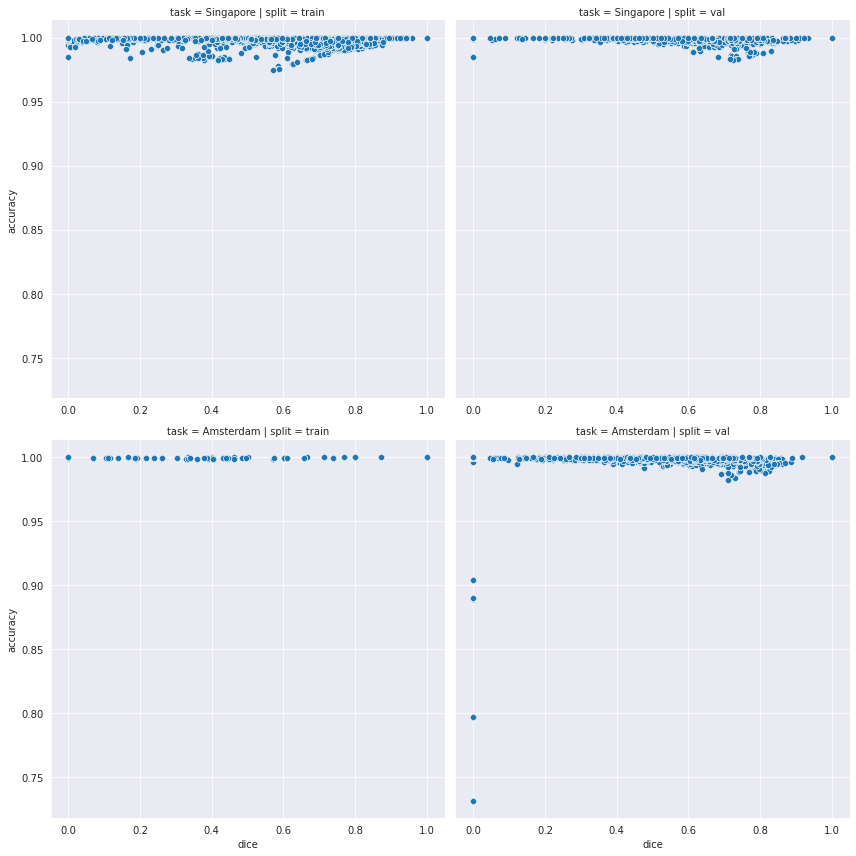

In [6]:
plt.rcParams.update({'font.size': 15})  

g = sns.relplot(
    data=all_logs,
    x='dice',
    y='accuracy',
    row='task',
    col='split',
    kind='scatter',
    height=6,
    facet_kws={"sharex": False}
    )

In [7]:
# Isolate the cases which have no-label and cases where there is at least some label.
def has_label(value):
    return (value != 0.0)

def weighted_metric(metric, weighting):
    return f"{metric}_{weighting}"

# Add some new useful columns
all_logs['has_label'] = all_logs['gt_lab_amount'].apply(has_label) 
all_logs['weighted_metric'] = all_logs.apply(lambda row: weighted_metric(row['cal_metric'], row['bin_weighting']), axis=1)

def reorder_splits(df):
    train_logs = df[df['split'] == 'train']
    val_logs = df[df['split'] == 'val']
    cal_logs = df[df['split'] == 'cal']
    fixed_df = pd.concat([train_logs, val_logs, cal_logs])
    return fixed_df

# Set the rows so that it's train, val, cal
all_logs = reorder_splits(all_logs)

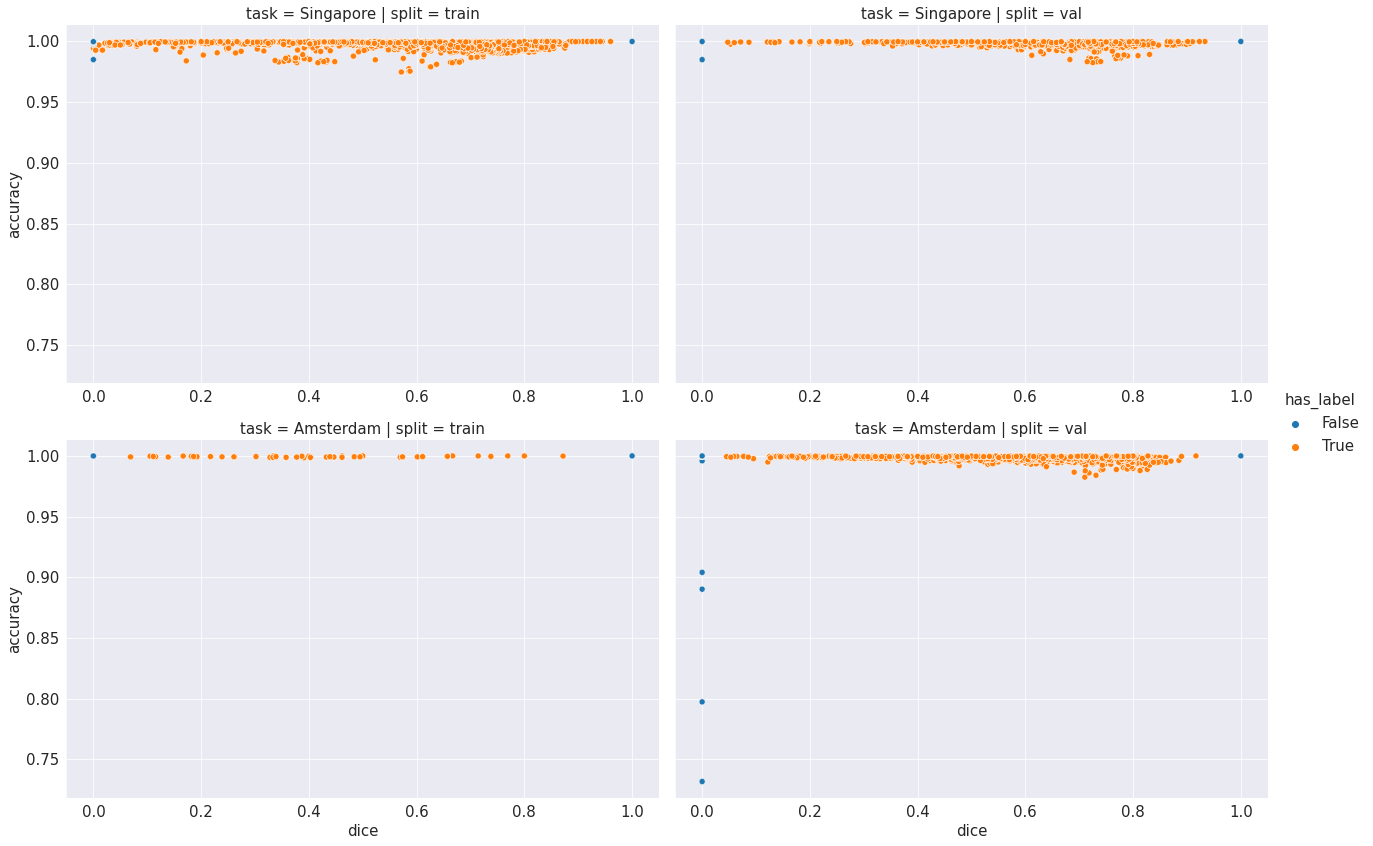

In [8]:
plt.rcParams.update({'font.size': 15})  

g = sns.relplot(
    data=all_logs,
    x='dice',
    y='accuracy',
    row='task',
    col='split',
    kind='scatter',
    hue='has_label',
    height=6,
    facet_kws={"sharex": False},
    aspect=1.5
    )

In [10]:
# Now we want to collapse the data by subject, so we can get the mean metric score for each subject.
logs_per_subject = all_logs.groupby(['data_idx', 'class_type', 'num_bins', 'cal_metric', 'bin_weighting', 'weighted_metric', 'task', 'split']).agg({
    'pred_lab_amount': 'mean',
    'gt_lab_amount': 'mean',
    'cal_score': 'mean',
    'accuracy': 'mean',
    'dice': 'mean',
    'lab_w_accuracy': 'mean'
}).reset_index()

logs_per_subject = reorder_splits(logs_per_subject)

In [ ]:
logs_per_subject

# Now for the graph we really care about, let's look at how each metric/weighting correlates first with dice.

In [11]:
# Define the color palette
metric_weight_palette = {
    'ECE_weighted': 'gold',  # green
    'ReCE_weighted': 'darkgreen'
}

# Group the metrics by important factors
grouped_logs = all_logs.groupby(['task', 'split', 'weighted_metric'])
grouped_logs_per_subject = logs_per_subject.groupby(['task', 'split', 'weighted_metric'])

In [ ]:
plt.rcParams.update({'font.size': 15})  

for metric in metric_weight_palette.keys():
    g = sns.relplot(
        data=logs[logs['weighted_metric'] == metric],
        x='accuracy',
        y='metric_score',
        col='split',
        hue='task',
        kind='scatter',
        height=8,
        facet_kws={"sharex": False},
        alpha=0.5,
        aspect=1
        )
    g.axes.flat[0].set_ylabel(metric)
    plt.show()

In [ ]:
# Group by the three columns and apply correlation
plt.rcParams.update({'font.size': 15})  
accuracy_correlations = grouped_logs.apply(lambda x: x['accuracy'].corr(x['metric_score'])).reset_index(name='accuracy correlation')
sns.catplot(data=accuracy_correlations, 
            x="weighted_metric", 
            y="accuracy correlation", 
            hue='task', 
            col="split", 
            kind="bar", 
            height=10, 
            aspect=1.5)

In [ ]:
plt.rcParams.update({'font.size': 15})  

for metric in metric_weight_palette.keys():
    g = sns.relplot(
        data=logs_per_subject[logs_per_subject['weighted_metric'] == metric],
        x='accuracy',
        y='metric_score',
        col='split',
        hue='task',
        kind='scatter',
        s=100,
        height=8,
        facet_kws={"sharex": False},
        alpha=0.8,
        aspect=1
        )
    g.axes.flat[0].set_ylabel(metric)
    plt.show()

In [ ]:
# Group by the three columns and apply correlation
accuracy_subject_correlations = grouped_logs_per_subject.apply(lambda x: x['accuracy'].corr(x['metric_score'])).reset_index(name='accuracy correlation')
accuracy_subject_correlations = reorder_splits(accuracy_subject_correlations)  
sns.catplot(data=accuracy_subject_correlations, x="weighted_metric", y="accuracy correlation", hue='task', col="split", kind="bar", height=10, aspect=1.5)

# Now how well does it correspond with dice score?

In [ ]:
plt.rcParams.update({'font.size': 15})  

for metric in metric_weight_palette.keys():
    g = sns.relplot(
        data=logs[logs['weighted_metric'] == metric],
        x='dice',
        y='metric_score',
        col='split',
        hue='task',
        kind='scatter',
        height=8,
        facet_kws={"sharex": False},
        alpha=0.5,
        aspect=1
        )
    g.axes.flat[0].set_ylabel(metric)
    plt.show()

In [ ]:
# Group by the three columns and apply correlation
dice_correlations = grouped_logs.apply(lambda x: x['dice'].corr(x['metric_score'])).reset_index(name='dice correlation')
dice_correlations = reorder_splits(dice_correlations)
g = sns.catplot(data=dice_correlations, 
            x="task", 
            y="dice correlation", 
            hue='weighted_metric', 
            col="split", 
            kind="bar", 
            height=10, 
            aspect=1.5)
# Set the y lim between - 1 and 1
g.set(ylim=(-1, 1))

In [ ]:
plt.rcParams.update({'font.size': 15})  

for metric in metric_weight_palette.keys():
    g = sns.relplot(
        data=logs_per_subject[logs_per_subject['weighted_metric'] == metric],
        x='dice',
        y='metric_score',
        col='split',
        hue='task',
        kind='scatter',
        s=100,
        height=8,
        facet_kws={"sharex": False},
        alpha=0.8,
        aspect=1
        )
    g.axes.flat[0].set_ylabel(metric)
    plt.show()

In [ ]:
# Group by the three columns and apply correlation
dice_subject_correlations = grouped_logs_per_subject.apply(lambda x: x['dice'].corr(x['metric_score'])).reset_index(name='dice correlation')
dice_subject_correlations = reorder_splits(dice_subject_correlations)
g = sns.catplot(data=dice_subject_correlations, 
                x="task", 
                y="dice correlation", 
                hue='weighted_metric', 
                col="split", 
                kind="bar", 
                height=10, 
                aspect=1.5)
# Set the y lim between - 1 and 1
g.set(ylim=(-1, 1))

# Or how they correlate with the amount of label in the groundtruth segmentation.

In [ ]:
from scipy.stats import pearsonr
plt.rcParams.update({'font.size': 15})  

for metric in metric_weight_palette.keys():
    g = sns.relplot(
        data=logs[logs['weighted_metric'] == metric],
        x='label_amount',
        y='metric_score',
        row='weighted_metric',
        col='split',
        hue='task',
        kind='scatter',
        height=8,
        facet_kws={"sharex": False},
        alpha=0.5,
        aspect=1
    )
    g.axes.flat[0].set_ylabel(metric)
    plt.show()

In [ ]:
# Group by the three columns and apply correlation
label_amount_correlations = logs.groupby(['task', 'split', 'weighted_metric']).apply(lambda x: x['label_amount'].corr(x['metric_score'])).reset_index(name='label amount correlation')
label_amount_correlations = reorder_splits(label_amount_correlations)
g = sns.catplot(data=label_amount_correlations, 
                x="task", 
                y="label amount correlation", 
                hue='weighted_metric', 
                col="split", 
                kind="bar", 
                height=10, 
                aspect=1.5)
# Set the y lim between - 1 and 1
g.set(ylim=(-1, 1))

In [ ]:
plt.rcParams.update({'font.size': 15})  

for metric in metric_weight_palette.keys():
    g = sns.relplot(
        data=logs_per_subject[logs_per_subject['weighted_metric'] == metric],
        x='label_amount',
        y='metric_score',
        col='split',
        hue='task',
        kind='scatter',
        s=100,
        height=8,
        facet_kws={"sharex": False},
        alpha=0.8,
        aspect=1
        )
    g.axes.flat[0].set_ylabel(metric)
    plt.show()

In [ ]:
# Group by the three columns and apply correlation
label_amount_subject_correlations = grouped_logs_per_subject.apply(lambda x: x['label_amount'].corr(x['metric_score'])).reset_index(name='label amount correlation')
label_amount_subject_correlations = reorder_splits(label_amount_subject_correlations)
sns.catplot(data=label_amount_subject_correlations, 
            x="task", 
            y="label amount correlation", 
            hue='weighted_metric', 
            col="split", 
            kind="bar", 
            height=10, 
            aspect=1.5)
# Set the y lim between - 1 and 1
g.set(ylim=(-1, 1))

# Finally we can look at weighted accuracy as well.

In [ ]:
plt.rcParams.update({'font.size': 15})  

for metric in metric_weight_palette.keys():
    g = sns.relplot(
        data=logs[logs['weighted_metric'] == metric],
        x='weighted_accuracy',
        y='metric_score',
        col='split',
        hue='task',
        kind='scatter',
        height=8,
        facet_kws={"sharex": False},
        alpha=0.5,
        aspect=1
    )
    g.axes.flat[0].set_ylabel(metric)
    plt.show()

In [ ]:
# Group by the three columns and apply correlation
weighted_accuracy_correlations = logs.groupby(['task', 'split', 'weighted_metric']).apply(lambda x: x['weighted_accuracy'].corr(x['metric_score'])).reset_index(name='weighted accuracy correlation')
weighted_accuracy_correlations = reorder_splits(weighted_accuracy_correlations)
sns.catplot(data=weighted_accuracy_correlations, x="weighted_metric", y="weighted accuracy correlation", hue='task', col="split", kind="bar", height=10, aspect=1.5)

In [ ]:
plt.rcParams.update({'font.size': 15})  

for metric in metric_weight_palette.keys():
    g = sns.relplot(
        data=logs_per_subject[logs_per_subject['weighted_metric'] == metric],
        x='weighted_accuracy',
        y='metric_score',
        col='split',
        hue='task',
        kind='scatter',
        s=100,
        height=8,
        facet_kws={"sharex": False},
        alpha=0.8,
        aspect=1
        )
    g.axes.flat[0].set_ylabel(metric)
    plt.show()

In [ ]:
# # Group by the three columns and apply correlation
# weighted_accuracy_subject_correlations = grouped_logs_per_subject.apply(lambda x: x['weighted_accuracy'].corr(x['metric_score'])).reset_index(name='weighted accuracy correlation')
# weighted_accuracy_subject_correlations = reorder_splits(weighted_accuracy_subject_correlations)
# g = sns.catplot(data=weighted_accuracy_subject_correlations, x="weighted_metric", y="weighted accuracy correlation", hue='task', col="split", kind="bar", height=10, aspect=1.5)
# # Set the y lim between - 1 and 1
# g.set(ylim=(-1, 1))